# Laboratorium

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import os

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
          
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points


class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)


class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

___

# Rozwiązanie

## Implementacja pomocniczych funkcji

In [3]:
%matplotlib notebook

In [4]:
def det_3x3(pt_a, pt_b, pt_c):
    return (pt_a[0]*pt_b[1] + pt_b[0]*pt_c[1] + pt_c[0]*pt_a[1]
           - pt_c[0]*pt_b[1] - pt_a[0]*pt_c[1] - pt_b[0]*pt_a[1])

In [5]:
def angle_orientation(pt_a, pt_b, pt_c, tolerance=10e-12):
    det_val = det_3x3(pt_a, pt_b, pt_c)
    
    if det_val > tolerance:
        return -1
    elif det_val < -tolerance:
        return 1
    else:
        return 0

## Zadawanie dowolnych figur na wykresie

In [6]:
def draw_plot(): 
    plot = Plot(points=[PointsCollection([(0, 0)], color='white')])
    plot.draw()
    return plot

In [7]:
def take_from_plot(plot, draw_closed_fig=True, save_txt=False, filename="drawn_points_0.txt"):
    lines = plot.get_added_figure()[0].lines
    num_lines = len(lines)

    first_pt = lines[0][0]
    if not first_pt == lines[-1][1]:
        last_pt = lines[-1][0]
        lines.pop(-1)
        lines.append([(last_pt),(first_pt)])
    
    if draw_closed_fig:
        plot = Plot(lines=[LinesCollection(lines)])
        plot.draw()

    points = list(map(lambda line: line[0], lines))
    
    if save_txt:
        results_directory = os.path.join(os.getcwd(), r"results")

        if not os.path.exists(results_directory):
            os.makedirs(results_directory)
        with open(os.path.join(results_directory, filename), "w") as file:
            for pt in points:
                file.write(f"{pt}\n")   
    
    return points, lines

## Zbiór danych nr 1

<IPython.core.display.Javascript object>


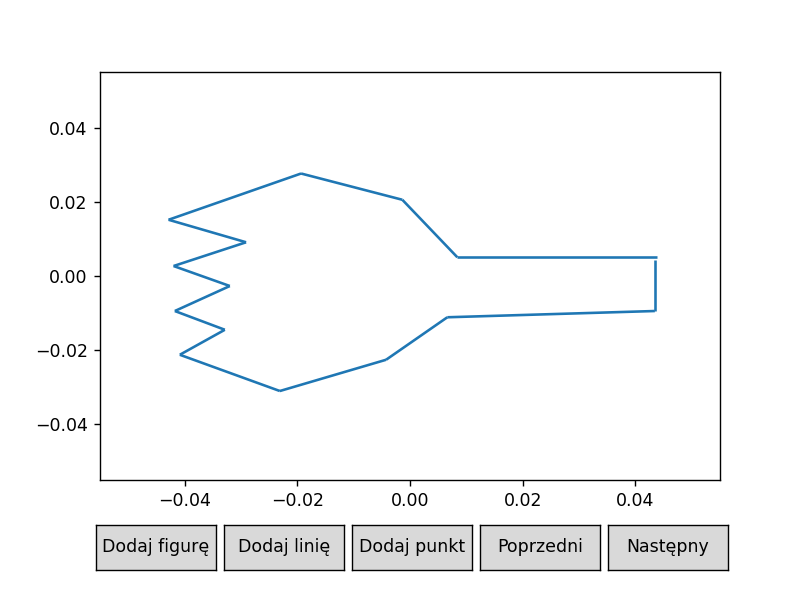

In [8]:
plot_fig_1 = draw_plot()

<IPython.core.display.Javascript object>


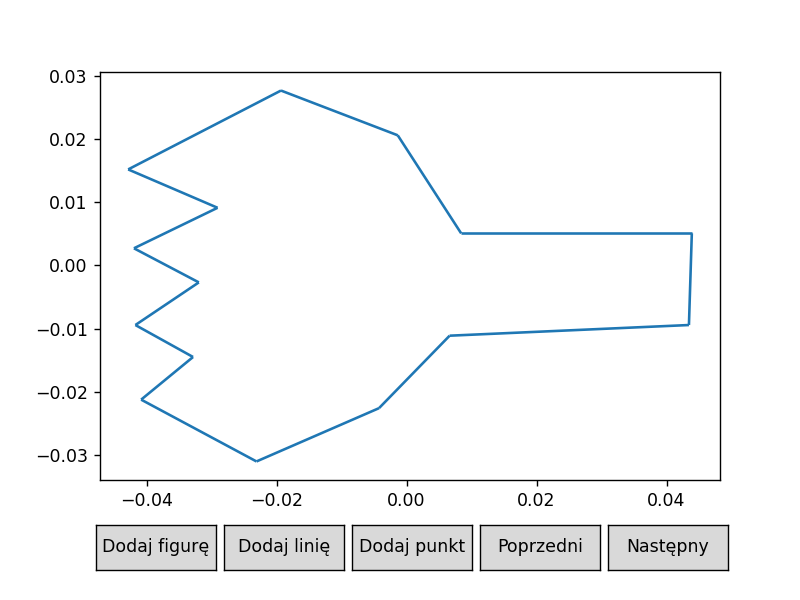

In [9]:
data_set_1 = take_from_plot(plot_fig_1, draw_closed_fig=True)

## Zbiór danych nr 2

<IPython.core.display.Javascript object>


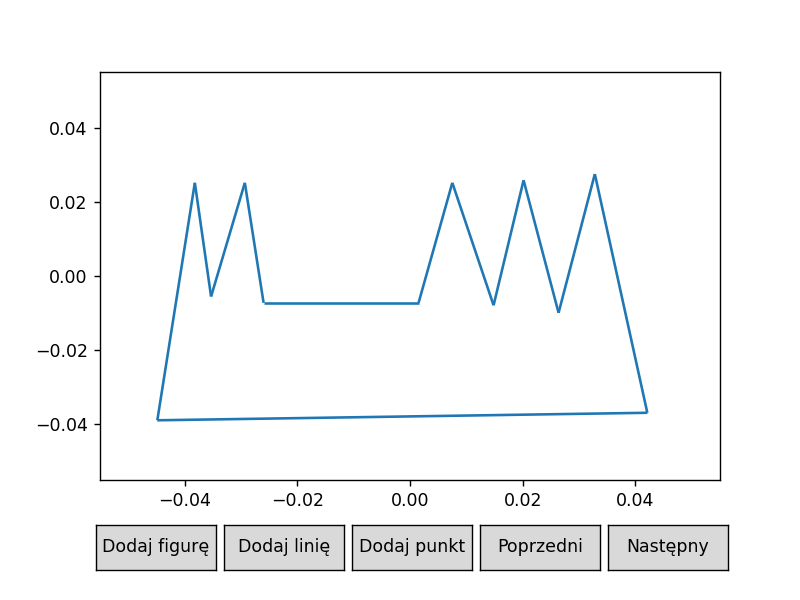

In [10]:
plot_fig_2 = draw_plot()

<IPython.core.display.Javascript object>


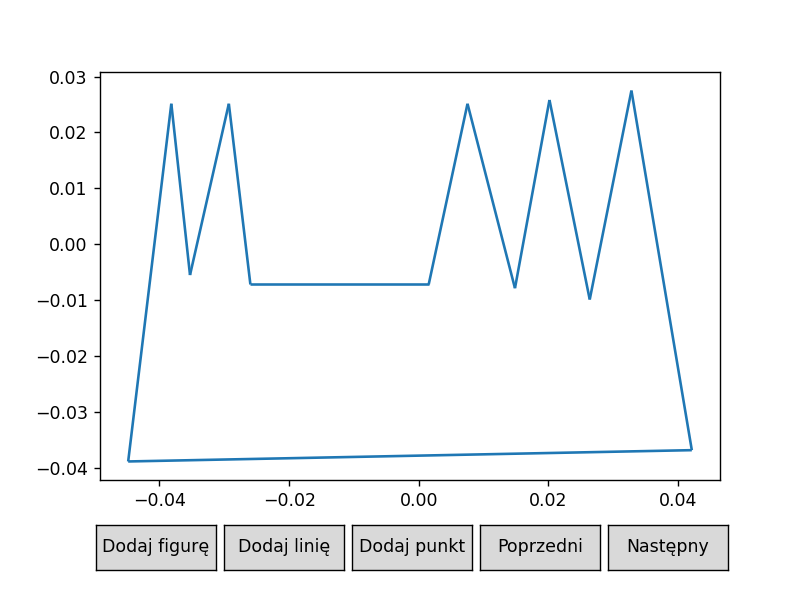

In [11]:
data_set_2 = take_from_plot(plot_fig_2, draw_closed_fig=True)

## Zbiór danych nr 3

<IPython.core.display.Javascript object>


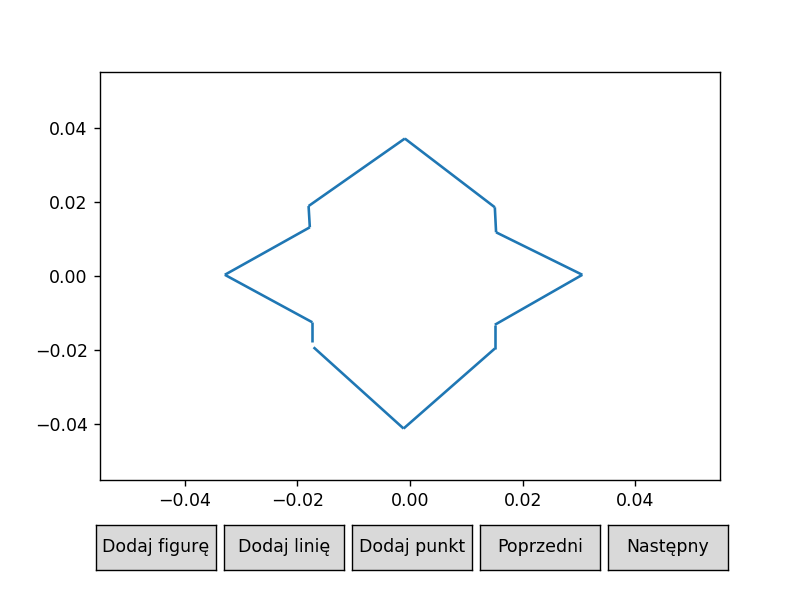

In [12]:
plot_fig_3 = draw_plot()

<IPython.core.display.Javascript object>


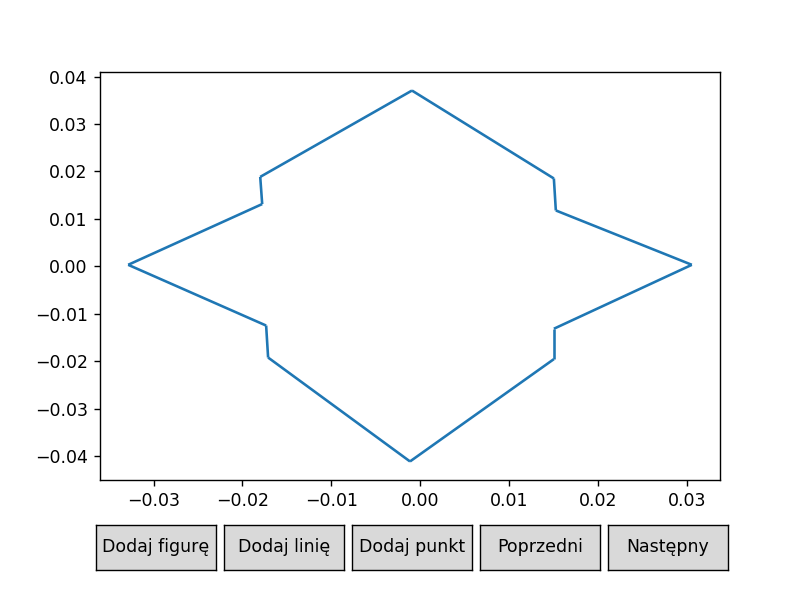

In [13]:
data_set_3 = take_from_plot(plot_fig_3, draw_closed_fig=True)

## Zbiór danych nr 4

<IPython.core.display.Javascript object>


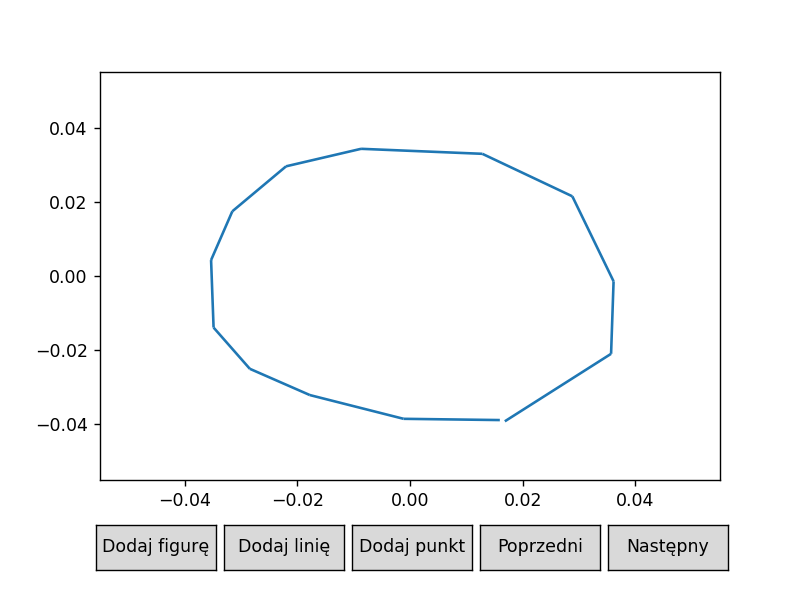

In [14]:
plot_fig_4 = draw_plot()

<IPython.core.display.Javascript object>


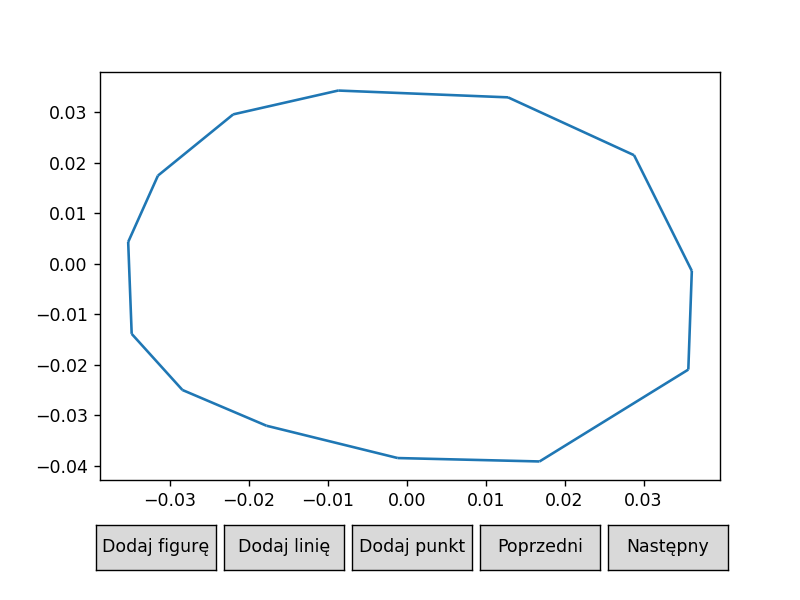

In [15]:
data_set_4 = take_from_plot(plot_fig_4, draw_closed_fig=True)

## Zbiór danych nr 5

<IPython.core.display.Javascript object>


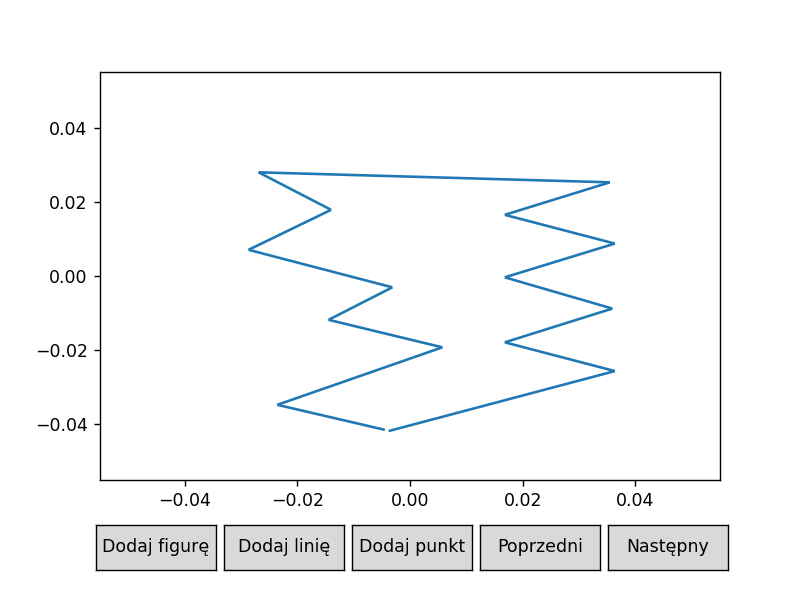

In [16]:
plot_fig_5 = draw_plot()

<IPython.core.display.Javascript object>


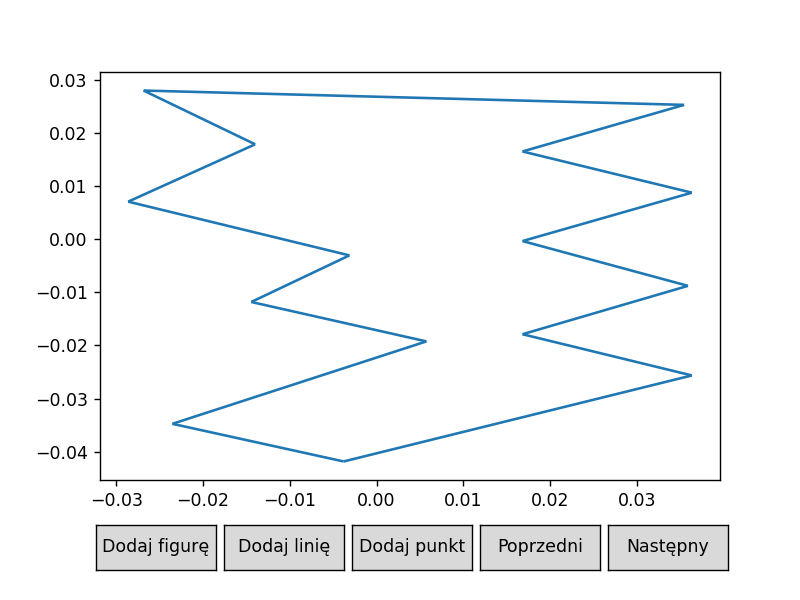

In [17]:
data_set_5 = take_from_plot(plot_fig_5, draw_closed_fig=True)

## Zbiór danych nr 6

<IPython.core.display.Javascript object>


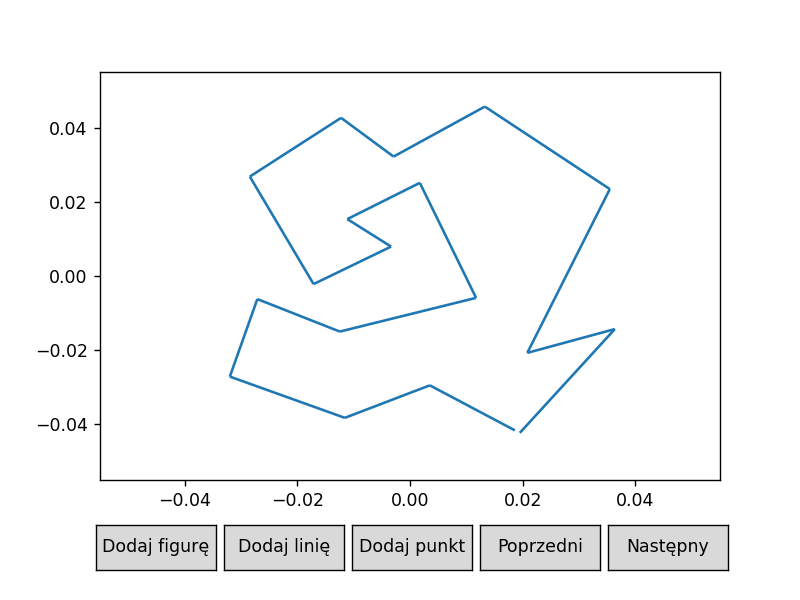

In [18]:
plot_fig_6 = draw_plot()

<IPython.core.display.Javascript object>


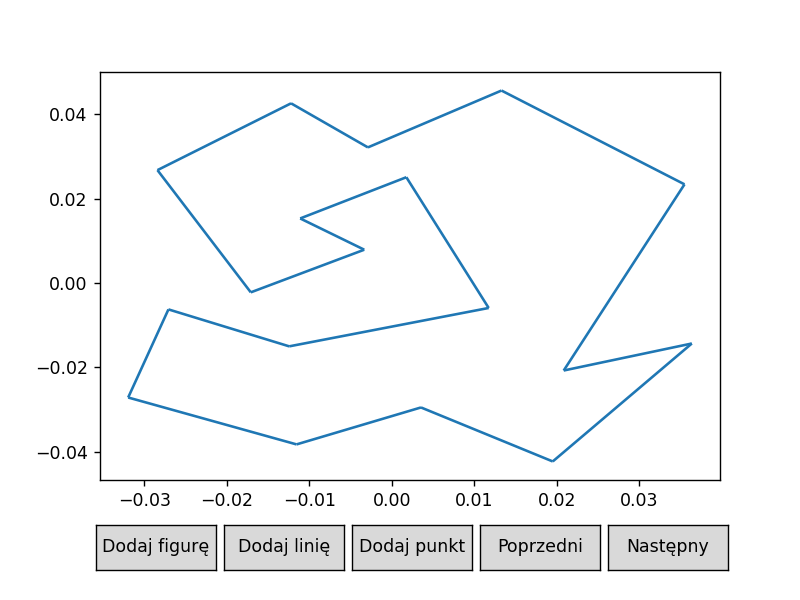

In [19]:
data_set_6 = take_from_plot(plot_fig_6, draw_closed_fig=True)

## Wyszukiwanie wierzchołków:
- początkowych
- końcowych
- łączących
- dzielących
- prawidłowych

In [20]:
def point_type(pt_a, pt_b, pt_c):
    if pt_a[1] < pt_b[1] and pt_c[1] < pt_b[1]:
        if angle_orientation(pt_a, pt_b, pt_c) == -1:
            return ("starting", pt_b)
        elif angle_orientation(pt_a, pt_b, pt_c) == 1:
            return ("dividing", pt_b)
    elif pt_a[1] > pt_b[1] and pt_c[1] > pt_b[1]:
        if angle_orientation(pt_a, pt_b, pt_c) == -1:
            return ("closing", pt_b)
        elif angle_orientation(pt_a, pt_b, pt_c) == 1:
            return ("connecting", pt_b)
    else:
        return ("correct", pt_b)

In [21]:
def points_classification(data_set):
    data_points = data_set[0]
    classification_keys = ["starting", "dividing", "closing", "connecting", "correct"]
    classified_points = {key: [] for key in classification_keys}
    
    for i in range(-2, len(data_points)-2):
        key, val = point_type(data_points[i], data_points[i+1], data_points[i+2])
        classified_points[key].append(val)
    
    return classified_points

In [22]:
def plot_classified_data(classified_data_set, data_set):
    data_lines = data_set[1]
    
    plot = Plot(lines=[LinesCollection(data_lines, color="silver")],
                points=[PointsCollection(classified_data_set["starting"], color="lime"),
                        PointsCollection(classified_data_set["dividing"], color="cyan"),
                        PointsCollection(classified_data_set["closing"], color="red"),
                        PointsCollection(classified_data_set["connecting"], color="blue"),
                        PointsCollection(classified_data_set["correct"], color="brown")])
    
    plot.draw()

## Klasyfikacja punktów zbioru nr 1

<IPython.core.display.Javascript object>


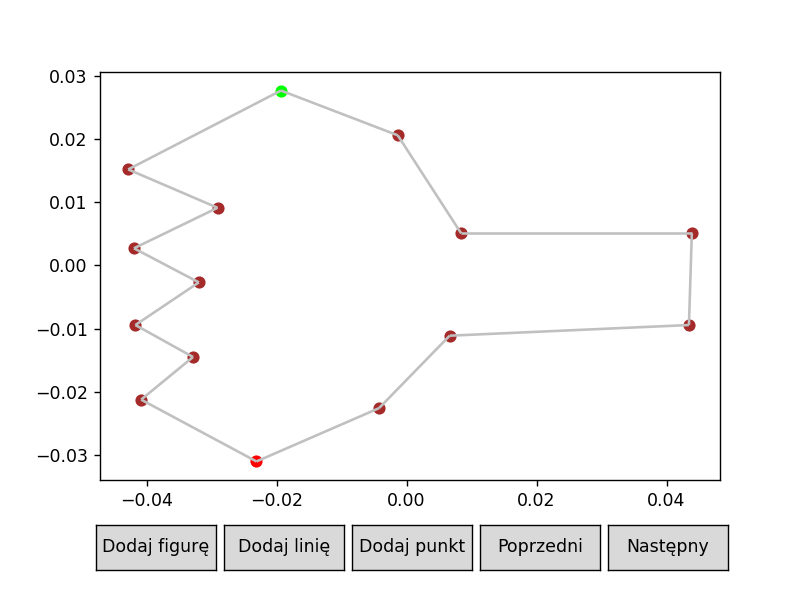

In [23]:
data_set_1_classified = points_classification(data_set_1)
plot_classified_data(data_set_1_classified, data_set_1)

## Klasyfikacja punktów zbioru nr 2

<IPython.core.display.Javascript object>


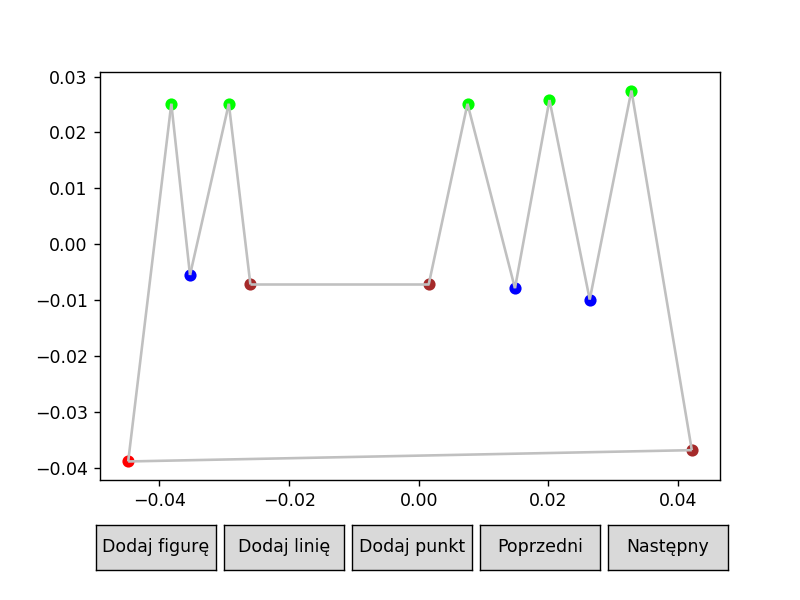

In [24]:
data_set_2_classified = points_classification(data_set_2)
plot_classified_data(data_set_2_classified, data_set_2)

## Klasyfikacja punktów zbioru nr 3

<IPython.core.display.Javascript object>


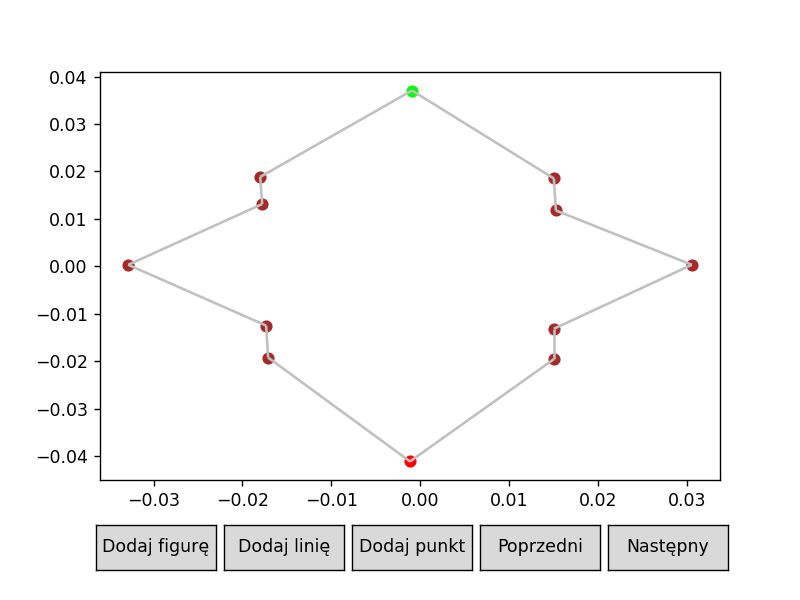

In [25]:
data_set_3_classified = points_classification(data_set_3)
plot_classified_data(data_set_3_classified, data_set_3)

## Klasyfikacja punktów zbioru nr 4

<IPython.core.display.Javascript object>


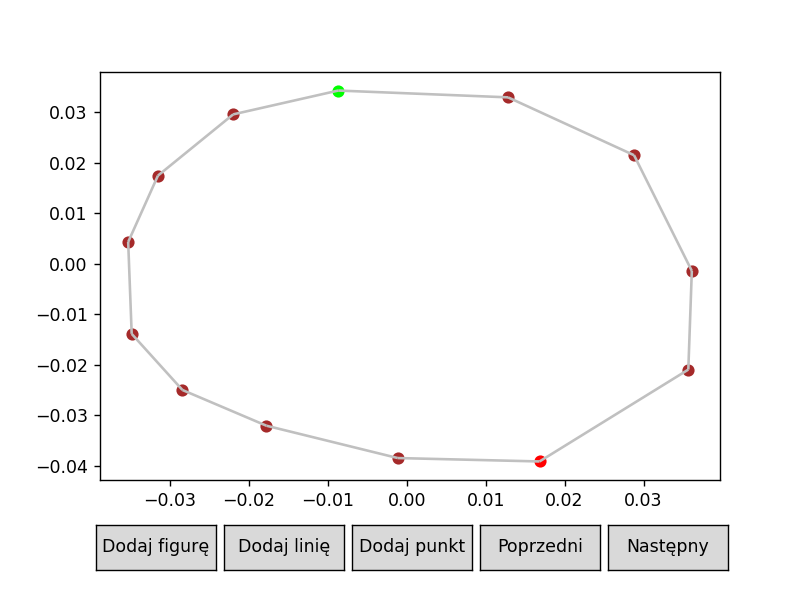

In [26]:
data_set_4_classified = points_classification(data_set_4)
plot_classified_data(data_set_4_classified, data_set_4)

## Klasyfikacja punktów zbioru nr 5

<IPython.core.display.Javascript object>


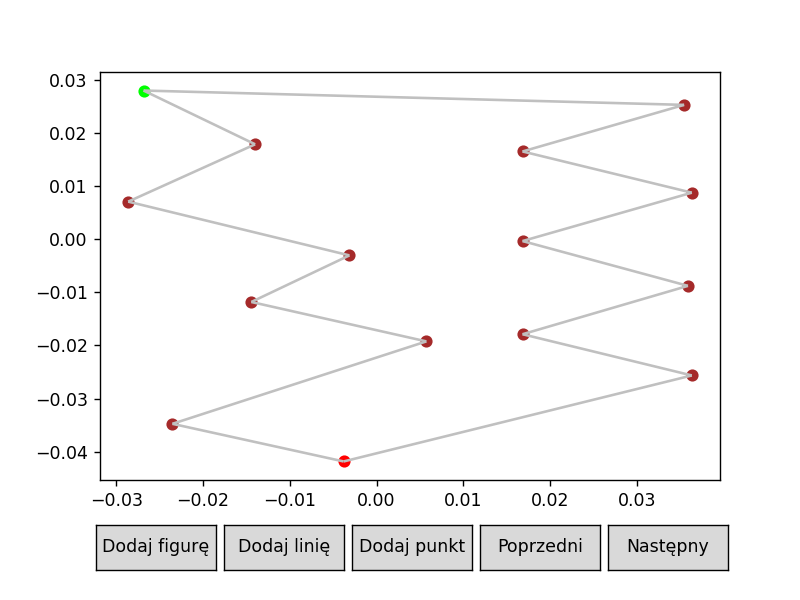

In [27]:
data_set_5_classified = points_classification(data_set_5)
plot_classified_data(data_set_5_classified, data_set_5)

## Klasyfikacja punktów zbioru nr 6

<IPython.core.display.Javascript object>


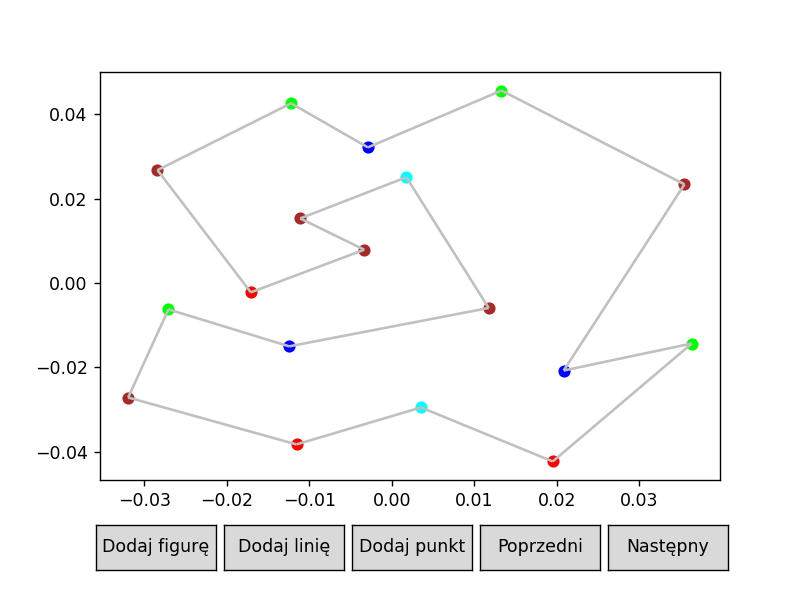

In [28]:
data_set_6_classified = points_classification(data_set_6)
plot_classified_data(data_set_6_classified, data_set_6)

## Sprawdzanie y-monotoniczności wielokąta

In [29]:
def check_monotonicity(data_set):
    data_points = data_set[0]
    
    for i in range(-2, len(data_points)-2):
        key, val = point_type(data_points[i], data_points[i+1], data_points[i+2])
        if key in ("dividing", "connecting"):
            return False
        
    return True 

## Triangulacja wielokąta monotonicznego

In [30]:
def split_chains(data_set):
    left, right = [], []
    data_points = data_set[0]
    max_y_pt = max(data_points, key=lambda x: x[1])
    min_y_pt = min(data_points, key=lambda x: x[1])
    max_y_pt_idx, min_y_pt_idx = data_points.index(max_y_pt), data_points.index(min_y_pt)
    
    for i in range(len(data_points)):
        if min_y_pt_idx < i and max_y_pt_idx > i:
            right.append(data_points[i])
        else:
            left.append(data_points[i])
            
    left.sort(key=lambda x: (x[1], x[0]), reverse=True)
    right.sort(key=lambda x: (x[1], x[0]), reverse=True)
            
    return left, right

In [31]:
def triangle_inside(pt_a, pt_b, pt_c, left, right):
    if pt_b in left:
        if angle_orientation == -1:
            return True
        else:
            return False
    
    if pt_b in right:
        if angle_orientation == -1:
            return False
        else:
            return True

In [32]:
def is_adjacent(pt_a, pt_b, data_points):
    index_difference = abs(data_points.index(pt_a) - data_points.index(pt_b))
    
    if index_difference in (1, len(data_points)-1):
        return True
    else:
        return False

In [33]:
def find_diagonal(pt_a, pt_b, pt_c, diagonals, data_points):
    if not is_adjacent(pt_a, pt_c, data_points) and [pt_a, pt_c] not in diagonals:
        return [pt_a, pt_c]
    
    if not is_adjacent(pt_b, pt_c, data_points) and [pt_b, pt_c] not in diagonals:
        return [pt_b, pt_c]
    
    return None

In [34]:
def generate_scene(points, lines, diagonals, stack=None, point=None, pt=None):
    if stack is None and point is None and pt is None:
        return Scene(lines=[LinesCollection(lines, color="black"),
                            LinesCollection(diagonals, color="blue")], 
                     points=[PointsCollection(points, color="green")])
    if pt is None:
        return Scene(lines=[LinesCollection(lines, color="black"),
                            LinesCollection(diagonals, color="blue")], 
                     points=[PointsCollection(points, color="green"),
                             PointsCollection(stack, color="red"),
                             PointsCollection([point], color="yellow")]) 
                     
    return Scene(lines=[LinesCollection(lines, color="black"),
                        LinesCollection(diagonals, color="blue")], 
                 points=[PointsCollection(points, color="green"),
                         PointsCollection(stack, color="red"),
                         PointsCollection([point], color="yellow"),
                         PointsCollection([pt], color="purple")])

In [35]:
def triangulate(data_set):
    data_points, data_lines = data_set[0], data_set[1]
    stack, diagonals, scenes = [], [], []
    
    if not check_monotonicity(data_set):
        print("Nie jest monotoniczny")
        return None, None
    
    scenes.append(Scene(points=[PointsCollection(data_points, color='green')],
                        lines=[LinesCollection(data_lines, color='black')]))

    left_chain, right_chain = split_chains(data_set)
    data_points_sorted = sorted(data_points, key=lambda x: (x[1], x[0]), reverse=True)
    stack.extend(data_points_sorted[:2])
    
    for i in range(2, len(data_points_sorted)):
        diagonals_now = diagonals.copy()
        stack_now = stack.copy()
        scenes.append(generate_scene(data_points_sorted, data_lines, diagonals_now,
                                     stack=stack_now, point=data_points_sorted[i]))
        compare_pts = set([stack[-1], data_points_sorted[i]])

        if compare_pts.issubset(left_chain) or compare_pts.issubset(right_chain):
            pt = stack.pop()
            while len(stack) > 0 and triangle_inside(stack[-1], pt, data_points_sorted[i], left_chain, right_chain):
                new_diagonal = find_diagonal(stack[-1], pt, data_points_sorted[i], diagonals, data_set[0])
                if new_diagonal is not None:
                    diagonals.append(new_diagonal)
                
                pt = stack.pop()
                diagonals_now = diagonals.copy()
                stack_now = stack.copy()
                scenes.append(generate_scene(data_points_sorted, data_lines, diagonals_now,
                                             stack=stack_now, point=data_points_sorted[i], pt=pt))
            stack.extend([pt, data_points_sorted[i]])    
        
        else:
            while len(stack) > 0:
                pt = stack.pop()
                if not is_adjacent(pt, data_points_sorted[i], data_set[0]):
                    diagonals.append([pt, data_points_sorted[i]])
                  
                diagonals_now = diagonals.copy()
                stack_now = stack.copy()
                scenes.append(generate_scene(data_points_sorted, data_lines, diagonals_now,
                                             stack=stack_now, point=data_points_sorted[i], pt=pt))          
            stack.extend([data_points_sorted[i-1], data_points_sorted[i]])
   
    diagonals_now = diagonals.copy()
    last_scene = generate_scene(data_points_sorted, data_lines, diagonals_now)
    scenes.append(last_scene)
    scenes.insert(0, last_scene)
                  
    return diagonals, scenes

## Triangulacja zbioru danych nr 1

<IPython.core.display.Javascript object>


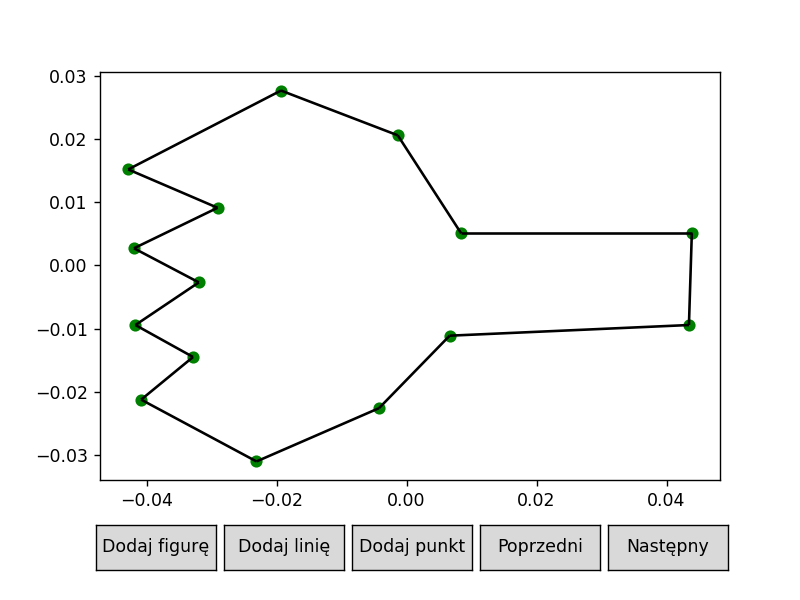

In [36]:
diagonals_1, scenes_1 = triangulate(data_set_1)
if diagonals_1 is not None and scenes_1 is not None:
    plot_triang_1 = Plot(scenes_1)
    plot_triang_1.draw()

## Triangulacja zbioru danych nr 3

<IPython.core.display.Javascript object>


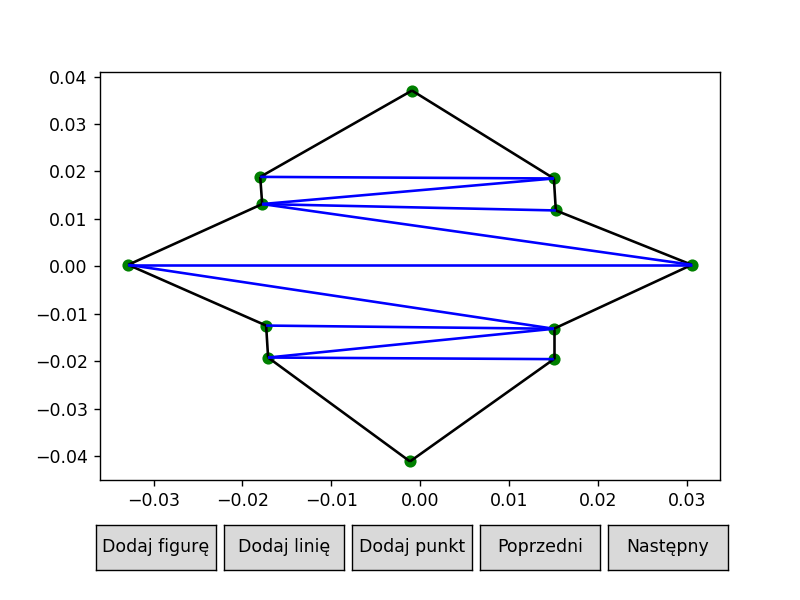

In [37]:
diagonals_3, scenes_3 = triangulate(data_set_3)
if diagonals_3 is not None and scenes_3 is not None:
    plot_triang_3 = Plot(scenes_3)
    plot_triang_3.draw()

## Triangulacja zbioru danych nr 4

<IPython.core.display.Javascript object>


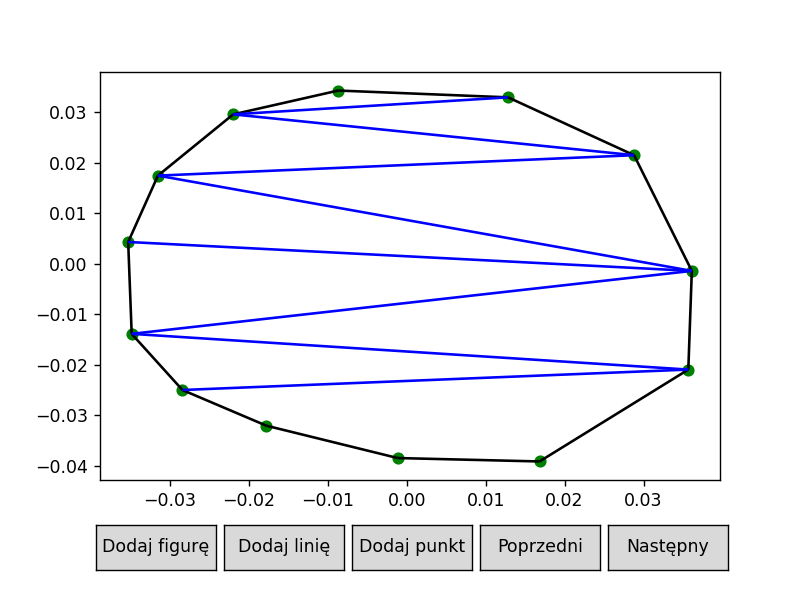

In [38]:
diagonals_4, scenes_4 = triangulate(data_set_4)
if diagonals_4 is not None and scenes_4 is not None:
    plot_triang_4 = Plot(scenes_4)
    plot_triang_4.draw()

## Triangulacja zbioru danych nr 5

<IPython.core.display.Javascript object>


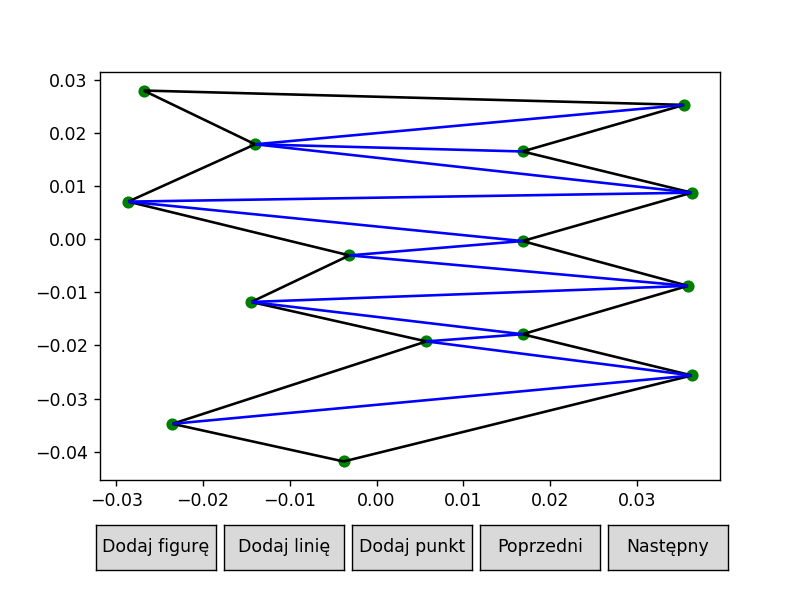

In [39]:
diagonals_5, scenes_5 = triangulate(data_set_5)
if diagonals_5 is not None and scenes_5 is not None:
    plot_triang_5 = Plot(scenes_5)
    plot_triang_5.draw()